In [1]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.optimize import minimize
from models import BoostingElementaryPredicates, BoostingElementaryPredicates1
from utilites import preprocess
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.datasets import load_boston
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import RepeatedKFold
from scipy.optimize import minimize
import numpy.ma as mask
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import LabelEncoder
from models import BoostingElementaryPredicates, BoostingElementaryPredicates1
import time
from tqdm import tqdm
import math
import itertools
from sklearn.datasets import load_diabetes
from sklearn.datasets import make_regression
import numpy as np
from sklearn.metrics import mean_squared_error
from joblib import Parallel, delayed
from own_forest import *
from utilites import *
from own_forest import *

## Алгоритм бэггинга над бустингом эл.кл.

In [6]:
def _generate_bagging_indices(rng, n_samples, sample_fraction, bootstrap):
    """Generates bootstrap indices for bagging."""
    if bootstrap:
        indices = rng.choice(n_samples, size=int(n_samples*sample_fraction), replace=True)
    else:
        indices = rng.choice(n_samples, size=int(n_samples*sample_fraction), replace=False)
    return indices

In [8]:
class BaggingElementaryTrees:
    def __init__(self, base_estimator=None, n_estimators=10, sub_sample_size=1.0, sub_feature_size=1.0, bootstrap=True, bootstrap_features=True, n_jobs=None, random_state=None):
        self.base_estimator = base_estimator if base_estimator is not None else BoostingElementaryPredicates()
        self.n_estimators = n_estimators
        self.sub_sample_size = sub_sample_size
        self.sub_feature_size = sub_feature_size
        self.bootstrap = bootstrap
        self.bootstrap_features = bootstrap_features
        self.n_jobs = n_jobs
        self.random_state = random_state

    def fit(self, X, y):
        self.random_state_ = np.random.RandomState(self.random_state)
        seeds = self.random_state_.randint(np.iinfo(np.int32).max, size=self.n_estimators)

        self.estimators_ = []
        self.estimators_features_ = []

        if self.n_jobs is None:
            for seed in seeds:
                estimator, features = self._fit_estimator(X, y, seed)
                self.estimators_.append(estimator)
                self.estimators_features_.append(features)
        else:
            results = Parallel(n_jobs=self.n_jobs)(delayed(self._fit_estimator)(X, y, seed) for seed in seeds)
            self.estimators_, self.estimators_features_ = zip(*results)

        return self

    def _fit_estimator(self, X, y, seed):
        rng = np.random.default_rng(seed)
        samples = _generate_bagging_indices(rng, X.shape[0], self.sub_sample_size, self.bootstrap)
        if self.bootstrap_features:
            features = _generate_bagging_indices(rng, X.shape[1], self.sub_feature_size, self.bootstrap)
        else:
            features = np.arange(X.shape[1])

        estimator = self.base_estimator.__class__() 
        estimator.fit(X[samples][:, features], y[samples])
        
        return estimator, features

    def predict(self, X):
        # Соберите предсказания от всех деревьев
        predictions = np.mean([est.predict(X[:, features]) for est, features in zip(self.estimators_, self.estimators_features_)], axis=0)
        return predictions

## Подготовка данных

In [6]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [35]:
# y = dataset['MPG'].to_numpy()
# X = dataset.drop(columns='MPG')

In [36]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
X_train, X_test, y_train, y_test = preprocess(dataset, 'MPG')

In [2]:
# diabetes = load_diabetes()
# X, y = diabetes.data, diabetes.target
# df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
# df['TARGET'] = diabetes.target

# X_train, X_test, y_train, y_test = preprocess(df)

## Обучение и подбор параметров бустинга

In [7]:
lb_params =  {
    "m" : np.linspace(5, 50, 10).astype(int),
    "num_iter" : np.linspace(10, 50, 20).astype(int),
    "max_cov": [500]
}

models = [BoostingElementaryPredicates()]

params = [lb_params]

In [8]:
results = []
time_results = []

In [9]:
for model, param in tqdm(zip(models, params)):
    start_time = time.time()
    grid = GridSearchCV(model, param, cv=5, scoring='neg_mean_squared_error')
    grid.fit(X_train, y_train)
    
    scores = cross_val_score(grid.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mse = np.abs(np.mean(scores))
    r2 = r2_score(y_test, grid.predict(X_test))
   
    results.append(f"{model.__class__.__name__}:\nBest params:{grid.best_params_}\nMSE: {mse:.2f}\nR2: {r2:.2f}\n")
    end_time = time.time()
    time_results.append({'model': model.__class__.__name__, 'time': end_time - start_time})

print('Results:')
for res in results:
    print(res)

print('\nTime results:')
for tres in time_results:
    print(tres)

1it [03:53, 233.45s/it]

Results:
BoostingElementaryPredicates:
Best params:{'m': 30, 'max_cov': 500, 'num_iter': 18}
MSE: 23.93
R2: 0.54


Time results:
{'model': 'BoostingElementaryPredicates', 'time': 233.45087599754333}


В предыдущей ячейке есть недочеты с подбором параметров (см. ниже графики)

11


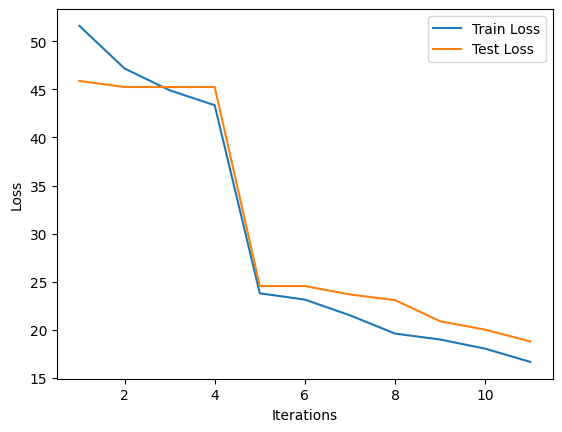

BoostingElementaryPredicates:
Mean Squared Error: 4.3362940399670515
R2 Score: 0.6502754378086654


In [8]:
model = BoostingElementaryPredicates1(num_iter=11, m=59) # критическое значение
model.fit_predict(X_train, y_train, X_test, y_test)
y_pred = model.predict(X_test)
print("BoostingElementaryPredicates:")
print("Mean Squared Error:", mean_squared_error(y_test, y_pred, squared=False))
print("R2 Score:", r2_score(y_test, y_pred))

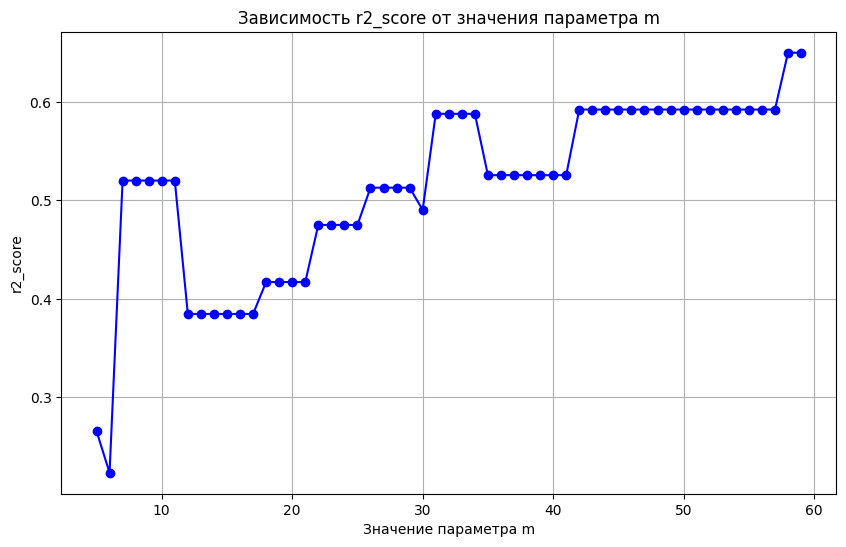

In [9]:
m_values = list(range(5, 60, 1)) # Равномерная сетка от 5 до 59
r2_scores = []

for m in m_values:
    model = BoostingElementaryPredicates(num_iter=11, m=m)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(m_values, r2_scores, marker='o', linestyle='-', color='b')
plt.title('Зависимость r2_score от значения параметра m')
plt.xlabel('Значение параметра m')
plt.ylabel('r2_score')
plt.grid(True)
plt.show()

Увеличение размерности матрицы сравнения позволяет достичь лучшего качества.

TODO: пофиксить краш ядра JupyterNotebook при матрицах размера >= 60 и посмотреть на распределение весов estimators.

## Обучение и подбор параметров бэггинга

In [11]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=0.5)

# Initializing and training the model
model = BaggingElementaryTrees(BoostingElementaryPredicates(num_iter=11, m=59), n_estimators=10, sub_sample_size=1.0, sub_feature_size=1.0, n_jobs=40, random_state=42)
rmse = train_and_validate(model, X_train, y_train, X_val, y_val, fraction=1.0, num_bags=10, num_iter=10, m=20)

print(f"Validation RMSE: {rmse}")

TypeError: 'NoneType' object cannot be interpreted as an integer

TODO: пофиксить обучение отдельного estimator'а бэггинга.

##  Эксперименты с различными долями признаков

In [36]:
# fractions = np.linspace(0.55, 1, 4)

# results = []

# for fraction in fractions:
#     rmse = train_and_validate(X_train, y_train, X_val, y_val, fraction, num_bags=10, num_iter=100, m=3)  # Пример параметров
#     results.append({'Fraction': fraction, 'RMSE': rmse})

In [ ]:
fracs = np.linspace(0.1, 1.0, 10)  # Диапазон долей признаков
rmses = []  # Список для хранения результатов

for frac in fracs:
    model = BaggingElementaryTrees(BoostingElementaryPredicates(num_iter=11, m=59), n_estimators=10, sub_feature_size=frac, bootstrap=True, bootstrap_features=True, n_jobs=-1, random_state=42)
    rmse = train_and_validate(model, X_train, y_train, X_val, y_val, fraction=frac, num_bags=10, num_iter=10, m=20)
    rmses.append(rmse)

# Отрисовка графиков
plt.figure(figsize=(10, 6))
plt.plot(fracs, rmses, marker='o', linestyle='-', color='b')
plt.title('Зависимость RMSE от доли признаков')
plt.xlabel('Доля признаков')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()